In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav
from scipy import interpolate
from scipy import signal
from IPython.display import Audio

In [2]:
music_rate, music_signal = wav.read('music.wav')
voice_rate, voice_signal = wav.read('sound.wav')
noise_1_rate, noise_1 = wav.read('noise1.wav')
noise_2_rate, noise_2 = wav.read('noise2.wav')
noise_3_rate, noise_3 = wav.read('noise3.wav')


In [3]:
def get_variance(snr, signal, noise):
    """
    Function that computes the required variance of the noise to achieve a given SNR.
    """
    #get the norm of the signal and the noise
    norm = np.linalg.norm(signal)**2
    noise_norm = np.linalg.norm(noise)**2
    #compute the variance
    variance = norm/(noise_norm*(np.exp(snr/10)))
    #variance = norm/(noise_norm*(10**(snr/10)))
    return variance

In [4]:
# sound_signal = voice_signal
# sound_rate = voice_rate
sound_signal = music_signal
sound_rate = music_rate
noise = noise_2
#sample a vector of the same size as the signal from the noise
added_noise = np.random.choice(noise, len(sound_signal), replace=True)
target_snr = 50
variance = get_variance(target_snr, sound_signal, added_noise)
noisy_signal = sound_signal + added_noise * np.sqrt(variance)

snr = 10*np.log(np.linalg.norm(sound_signal)**2/np.linalg.norm(noisy_signal-sound_signal)**2)

print("Target SNR: ", target_snr)
print('SNR: ', snr)
print('Variance: ', variance)

Target SNR:  50
SNR:  50.0
Variance:  0.0066643229504507896


### Spectral subtraction

With τ the time frame index, ν the frequency index, Y the STFT of the noisy signal, S $_n$ the STFT of the noise vector, and coefficients λ, α, β, γ, the formula to get back the denoised signal using spectral substraction is:

$ X(τ,ν) = Y(τ,ν) * (1 - (\frac{λ^α*|S_n(ν)|^α}{|Y(τ,ν)|^α)})^β \text{ if } |Y(τ,ν)|^α > λ^α |S_n(ν)|^α \text{, else } γ \frac{Y(τ,ν)}{|Y(τ,ν)|} |S_n(ν)| $

In [5]:
def spectral_subtraction(noisy_signal, sample_rate, noise, λ, α, β, γ):
    """ 
    Function that removes the noise from a noisy signal using spectral subtraction.
    """
    #compute the stft of the signal
    f, t, Zxx = signal.stft(noisy_signal, sample_rate, nperseg=1024)
    #compute the stft of the noise
    _, _, fft_noise = signal.stft(noise, sample_rate, nperseg=1024)
    #take the first window of the noise stft and duplicate it to the size of Zxx
    fft_noise = np.tile(fft_noise[:,0], (Zxx.shape[1], 1)).T
    
    
    result = np.where((np.abs(Zxx)**α) > (λ**α)*(np.abs(fft_noise)**α), 
                    Zxx * (1 - (λ**α*np.abs(fft_noise)**α)/(np.abs(Zxx)**α))**β,
                    γ*Zxx/np.abs(Zxx)*fft_noise)
    return result

##### Original (noised)

In [6]:
sample_rate = music_rate
#display noisy signal audio object
Audio(noisy_signal, rate=sample_rate)

##### Denoised

In [7]:
#spectral denoise
λ, α, β, γ = 2, 1, 1, 0.01


result = spectral_subtraction(noisy_signal, sample_rate, noise, λ, α, β, γ)

#compute the istft of the result
_, denoised_signal = signal.istft(result, sample_rate)
#display denoised signal audio object
Audio(denoised_signal, rate=sample_rate)


##### Trying it with a voice message.

In [8]:
sound_signal = voice_signal
sound_rate = voice_rate
noise = noise_1
#sample a vector of the same size as the signal from the noise
added_noise = np.random.choice(noise, len(sound_signal), replace=True)
target_snr = 30
variance = get_variance(target_snr, sound_signal, added_noise)
noisy_signal = sound_signal + added_noise * np.sqrt(variance)

snr = 10*np.log(np.linalg.norm(sound_signal)**2/np.linalg.norm(noisy_signal-sound_signal)**2)

print("Target SNR: ", target_snr)
print('SNR: ', snr)
print('Variance: ', variance)

Target SNR:  30
SNR:  30.0
Variance:  0.008773564304687207


##### Original

In [9]:
#display noisy signal audio object
Audio(noisy_signal, rate=sample_rate)

##### Denoised

In [10]:
#spectral denoise
λ, α, β, γ = 4, 1, 1, 0.001
sample_rate = music_rate

result = spectral_subtraction(noisy_signal, sample_rate, noise, λ, α, β, γ)

#compute the istft of the result
_, denoised_signal = signal.istft(result, sample_rate)
#display denoised signal audio object
Audio(denoised_signal, rate=sample_rate)


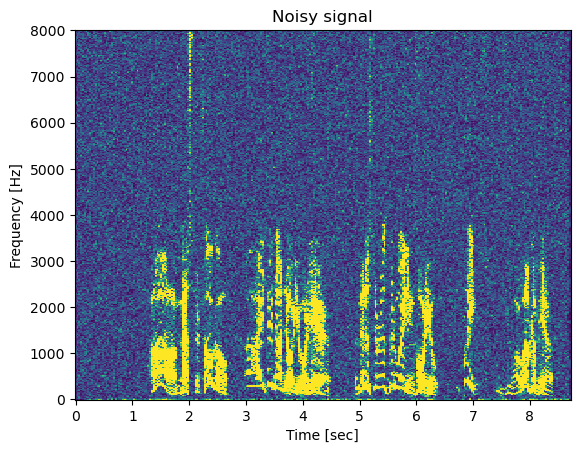

In [11]:
# plot the spectrogram of the noisy signal
f, t, Zxx = signal.stft(noisy_signal, sample_rate, nperseg=1024)
plt.pcolormesh(t, f, np.abs(Zxx), vmin=0, vmax=100)
plt.title('Noisy signal')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

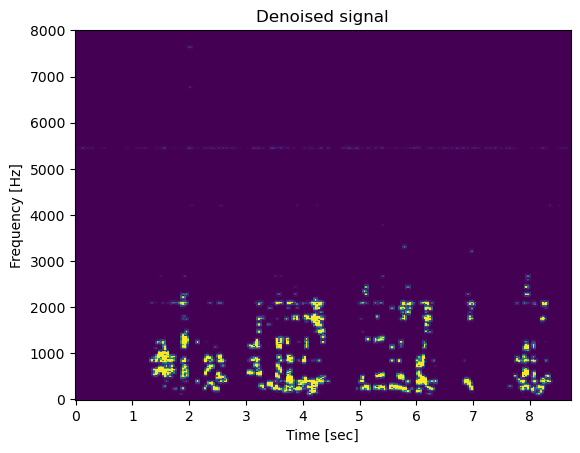

In [12]:
#plot the spectrogram of the denoised signal
f, t, Zxx = signal.stft(denoised_signal, sample_rate, nperseg=1024)
plt.pcolormesh(t, f, np.abs(Zxx), vmin=0, vmax=100)
plt.title('Denoised signal')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()


##### Coefficient roles:

λ determines the sensitivity to noise; the higher the λ, the stronger the signal has to be to satisfy the condition for spectral subtraction.

α, β control the magnitude of the attenuation of the noise.

γ determines the scaling factor of the signal when the spectral subtraction condition is not met; setting it to zero will turn the equation into a max(spectral_subtraction, 0).